In [1]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings("ignore")

In [2]:
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])

    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return tr_df

In [3]:
def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])

    ts_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return ts_df

In [4]:
tr_df = train_df('/kaggle/input/brain-tumor-mri-dataset/Training')


In [5]:
tr_df

,Class Path,Class
0,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
...,...,...
5707,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5708,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5709,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5710,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma


In [6]:
ts_df = test_df('/kaggle/input/brain-tumor-mri-dataset/Testing')

In [7]:
ts_df

,Class Path,Class
0,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
...,...,...
1306,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1307,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1308,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1309,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma


In [8]:
valid_df, ts_df = train_test_split(ts_df, train_size=0.5, random_state=42, stratify=ts_df['Class'])

In [9]:
valid_df

,Class Path,Class
537,/kaggle/input/brain-tumor-mri-dataset/Testing/...,notumor
734,/kaggle/input/brain-tumor-mri-dataset/Testing/...,meningioma
470,/kaggle/input/brain-tumor-mri-dataset/Testing/...,notumor
1169,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
996,/kaggle/input/brain-tumor-mri-dataset/Testing/...,meningioma
...,...,...
882,/kaggle/input/brain-tumor-mri-dataset/Testing/...,meningioma
1138,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1120,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
458,/kaggle/input/brain-tumor-mri-dataset/Testing/...,notumor


In [10]:
batch_size = 32
img_size = (299, 299)

_gen = ImageDataGenerator(rescale=1/255,
                          brightness_range=(0.8, 1.2))

ts_gen = ImageDataGenerator(rescale=1/255)


tr_gen = _gen.flow_from_dataframe(tr_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size)

valid_gen = _gen.flow_from_dataframe(valid_df, x_col='Class Path',
                                     y_col='Class', batch_size=batch_size,
                                     target_size=img_size)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col='Class Path',
                                  y_col='Class', batch_size=16,
                                  target_size=img_size, shuffle=False)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


In [11]:
img_shape=(299,299,3)
base_model = tf.keras.applications.Xception(include_top= False, weights= "imagenet",
                            input_shape= img_shape, pooling= 'max')

base_model.trainable = False

inputs = Input(shape = img_shape)

x = base_model(inputs)

x = Flatten()(x)

x = Dropout(rate= 0.3)(x)
x = Dense(128, activation= 'relu')(x)
x = Dropout(rate= 0.25)(x)
x = Dense(4, activation= 'softmax')(x)
    
model = Model(inputs, x)

model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


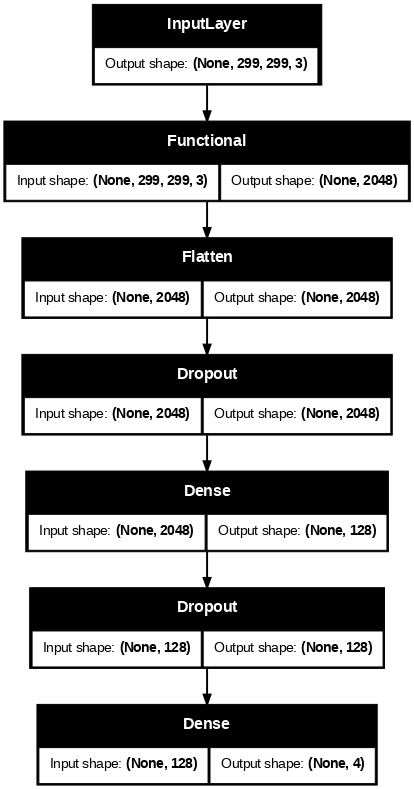

In [12]:
tf.keras.utils.plot_model(model, show_shapes=True, to_file='/kaggle/working/model.png', dpi=70,)

In [13]:
hist = model.fit(tr_gen,
                 epochs=5,
                 validation_data=valid_gen,
                 shuffle= False)

Epoch 1/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 81s 377ms/step - accuracy: 0.6212 - loss: 1.1539 - precision: 0.6696 - recall: 0.5443 - val_accuracy: 0.8427 - val_loss: 0.4291 - val_precision: 0.8792 - val_recall: 0.8000
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 36s 198ms/step - accuracy: 0.8162 - loss: 0.5010 - precision: 0.8488 - recall: 0.7834 - val_accuracy: 0.8550 - val_loss: 0.3737 - val_precision: 0.8740 - val_recall: 0.8366
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 35s 195ms/step - accuracy: 0.8424 - loss: 0.4112 - precision: 0.8665 - recall: 0.8150 - val_accuracy: 0.8641 - val_loss: 0.3339 - val_precision: 0.8811 - val_recall: 0.8489
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 36s 201ms/step - accuracy: 0.8725 - loss: 0.3471 - precision: 0.8919 - recall: 0.8492 - val_accuracy: 0.8855 - val_loss: 0.3062 - val_precision: 0.8966 - val_recall: 0.8733
Epoch 5/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 37s 206ms/step - accuracy: 0.8757 - loss: 0.3318 - precision: 0.8893 - recall: 0.8604 - val_accuracy: 0.8916 - va

In [14]:
hist.history.keys()

dict_keys(['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall'])

In [15]:
tr_gen.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [16]:
len(base_model.layers)

133

In [17]:
base_model.trainable = True
for layer in base_model.layers[:50]:
    layer.trainable = False

model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])

history_fine = model.fit(tr_gen,
                 epochs=5,
                 validation_data=valid_gen,
                 shuffle= False)

Epoch 1/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 96s 380ms/step - accuracy: 0.8816 - loss: 0.3642 - precision_1: 0.9045 - recall_1: 0.8572 - val_accuracy: 0.9878 - val_loss: 0.0429 - val_precision_1: 0.9893 - val_recall_1: 0.9863
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 52s 289ms/step - accuracy: 0.9864 - loss: 0.0387 - precision_1: 0.9884 - recall_1: 0.9864 - val_accuracy: 0.9817 - val_loss: 0.0768 - val_precision_1: 0.9832 - val_recall_1: 0.9817
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 52s 290ms/step - accuracy: 0.9947 - loss: 0.0138 - precision_1: 0.9951 - recall_1: 0.9947 - val_accuracy: 0.9893 - val_loss: 0.0309 - val_precision_1: 0.9893 - val_recall_1: 0.9893
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 52s 289ms/step - accuracy: 0.9957 - loss: 0.0156 - precision_1: 0.9960 - recall_1: 0.9957 - val_accuracy: 0.9893 - val_loss: 0.0345 - val_precision_1: 0.9893 - val_recall_1: 0.9893
Epoch 5/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 52s 288ms/step - accuracy: 0.9969 - loss: 0.0091 - precision_1: 0.9969 - recall_1

In [18]:
model.save("/kaggle/working/brain_tumor.h5")

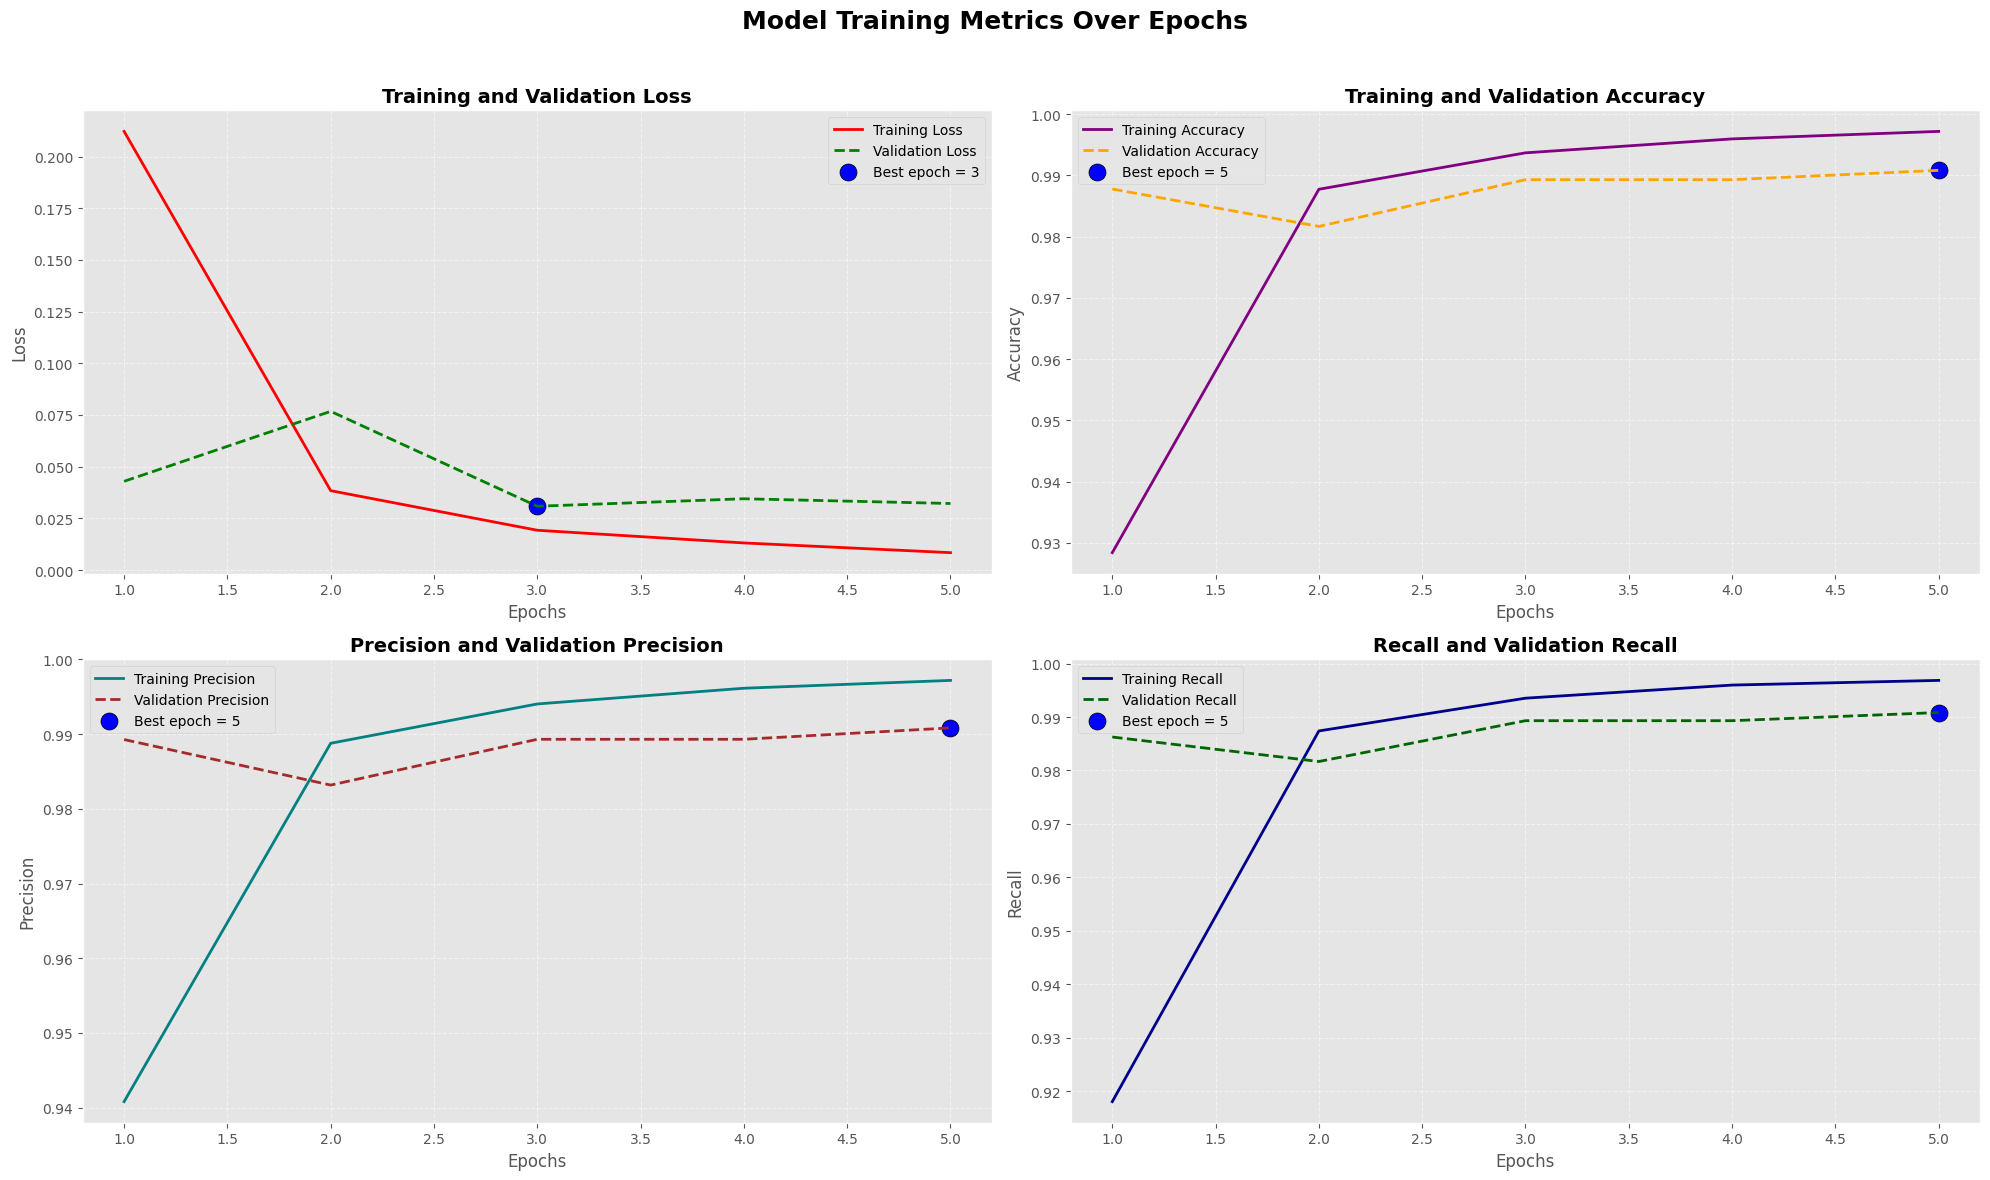

In [21]:
tr_acc = history_fine.history['accuracy']
tr_loss = history_fine.history['loss']
tr_per = history_fine.history['precision_1']
tr_recall = history_fine.history['recall_1']
val_acc = history_fine.history['val_accuracy']
val_loss = history_fine.history['val_loss']
val_per = history_fine.history['val_precision_1']
val_recall = history_fine.history['val_recall_1']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'

plt.style.use('ggplot')
plt.figure(figsize=(20, 12))

plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, color='red', label='Training Loss', linewidth=2)
plt.plot(Epochs, val_loss, color='green', label='Validation Loss', linestyle='--', linewidth=2)
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label, edgecolors='black')
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.grid(visible=True, linestyle='--', alpha=0.5)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, color='purple', label='Training Accuracy', linewidth=2)
plt.plot(Epochs, val_acc, color='orange', label='Validation Accuracy', linestyle='--', linewidth=2)
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label, edgecolors='black')
plt.title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=10)
plt.grid(visible=True, linestyle='--', alpha=0.5)

plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, color='teal', label='Training Precision', linewidth=2)
plt.plot(Epochs, val_per, color='brown', label='Validation Precision', linestyle='--', linewidth=2)
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label, edgecolors='black')
plt.title('Precision and Validation Precision', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.legend(fontsize=10)
plt.grid(visible=True, linestyle='--', alpha=0.5)

plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, color='darkblue', label='Training Recall', linewidth=2)
plt.plot(Epochs, val_recall, color='darkgreen', label='Validation Recall', linestyle='--', linewidth=2)
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label, edgecolors='black')
plt.title('Recall and Validation Recall', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Recall', fontsize=12)
plt.legend(fontsize=10)
plt.grid(visible=True, linestyle='--', alpha=0.5)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [20]:
print(history_fine.history.keys())


dict_keys(['accuracy', 'loss', 'precision_1', 'recall_1', 'val_accuracy', 'val_loss', 'val_precision_1', 'val_recall_1'])


In [22]:
train_score = model.evaluate(tr_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(ts_gen, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")

179/179 ━━━━━━━━━━━━━━━━━━━━ 34s 191ms/step - accuracy: 0.9999 - loss: 3.4110e-04 - precision_1: 0.9999 - recall_1: 0.9999
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step - accuracy: 0.9913 - loss: 0.0372 - precision_1: 0.9913 - recall_1: 0.9913
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - accuracy: 0.9956 - loss: 0.0147 - precision_1: 0.9956 - recall_1: 0.9956
Train Loss: 0.0006
Train Accuracy: 99.98%
--------------------
Validation Loss: 0.0303
Validation Accuracy: 99.08%
--------------------
Test Loss: 0.0123
Test Accuracy: 99.70%


In [23]:
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step


In [24]:
class_dict = tr_gen.class_indices

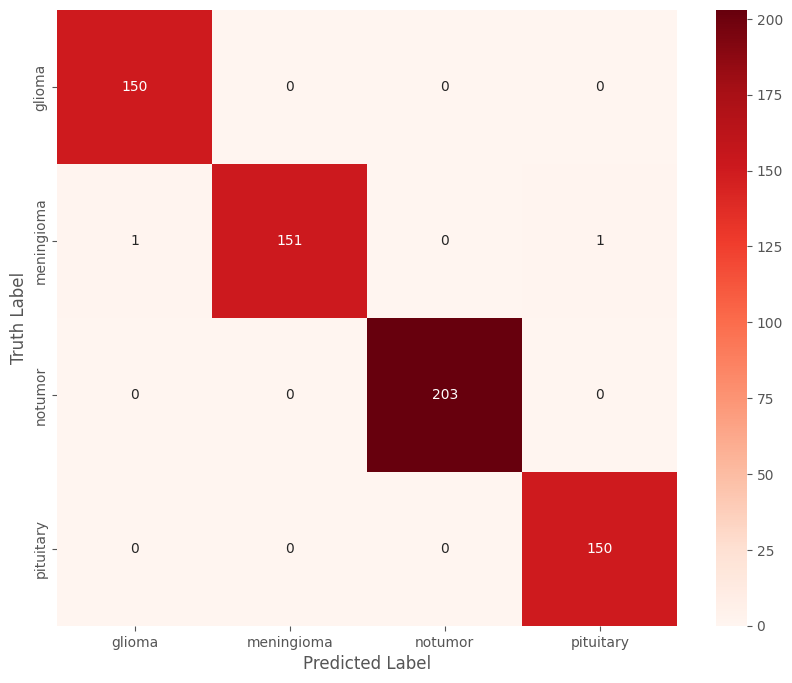

In [25]:
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

In [26]:
clr = classification_report(ts_gen.classes, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       150
           1       1.00      0.99      0.99       153
           2       1.00      1.00      1.00       203
           3       0.99      1.00      1.00       150

    accuracy                           1.00       656
   macro avg       1.00      1.00      1.00       656
weighted avg       1.00      1.00      1.00       656



In [27]:
def predict(img_path):
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image
    label = list(class_dict.keys())
    plt.figure(figsize=(12, 12))
    img = Image.open(img_path)
    resized_img = img.resize((299, 299))
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    img = img / 255
    predictions = model.predict(img)
    probs = list(predictions[0])
    labels = label
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()

In [31]:
import os
print(os.listdir("/kaggle/input/brain-tumor-mri-dataset/Testing/"))


['pituitary', 'notumor', 'meningioma', 'glioma']


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


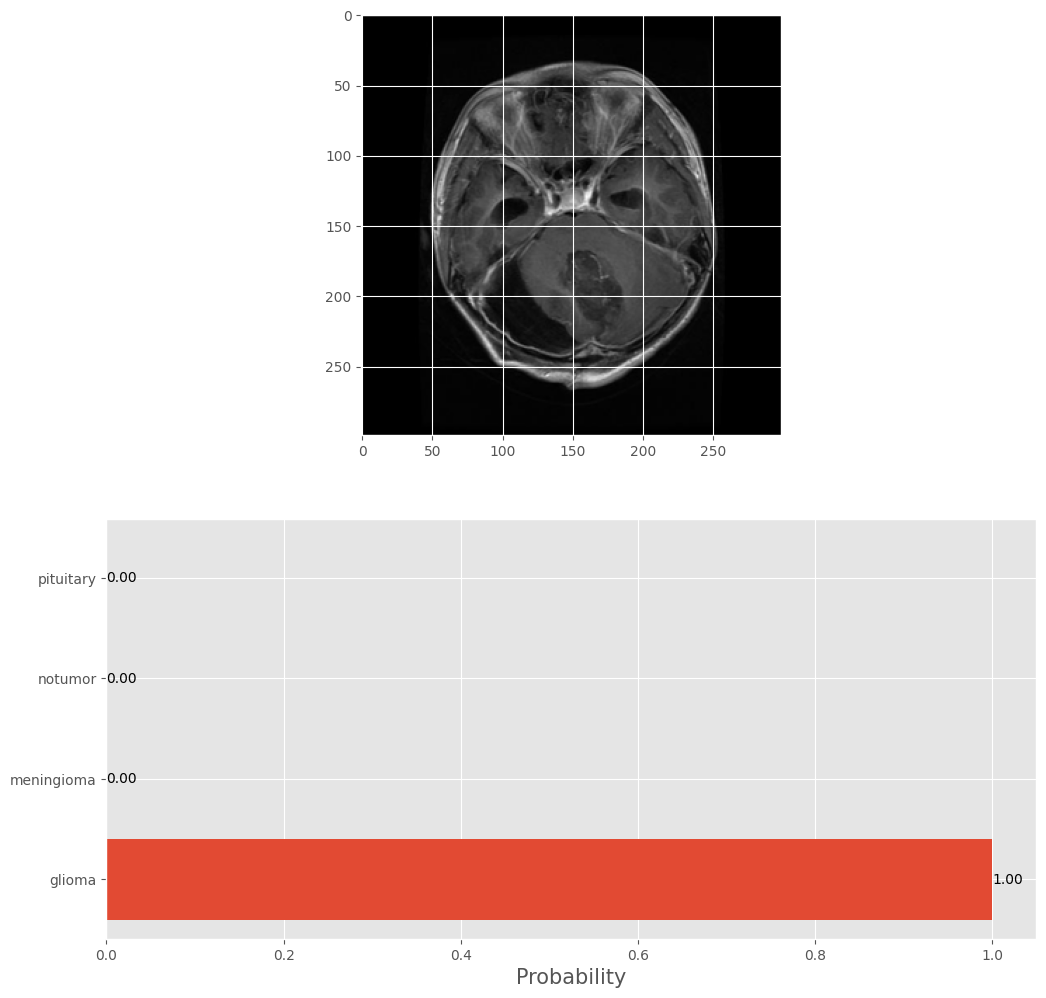

In [32]:
predict('/kaggle/input/brain-tumor-mri-dataset/Testing/glioma/Te-glTr_0000.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


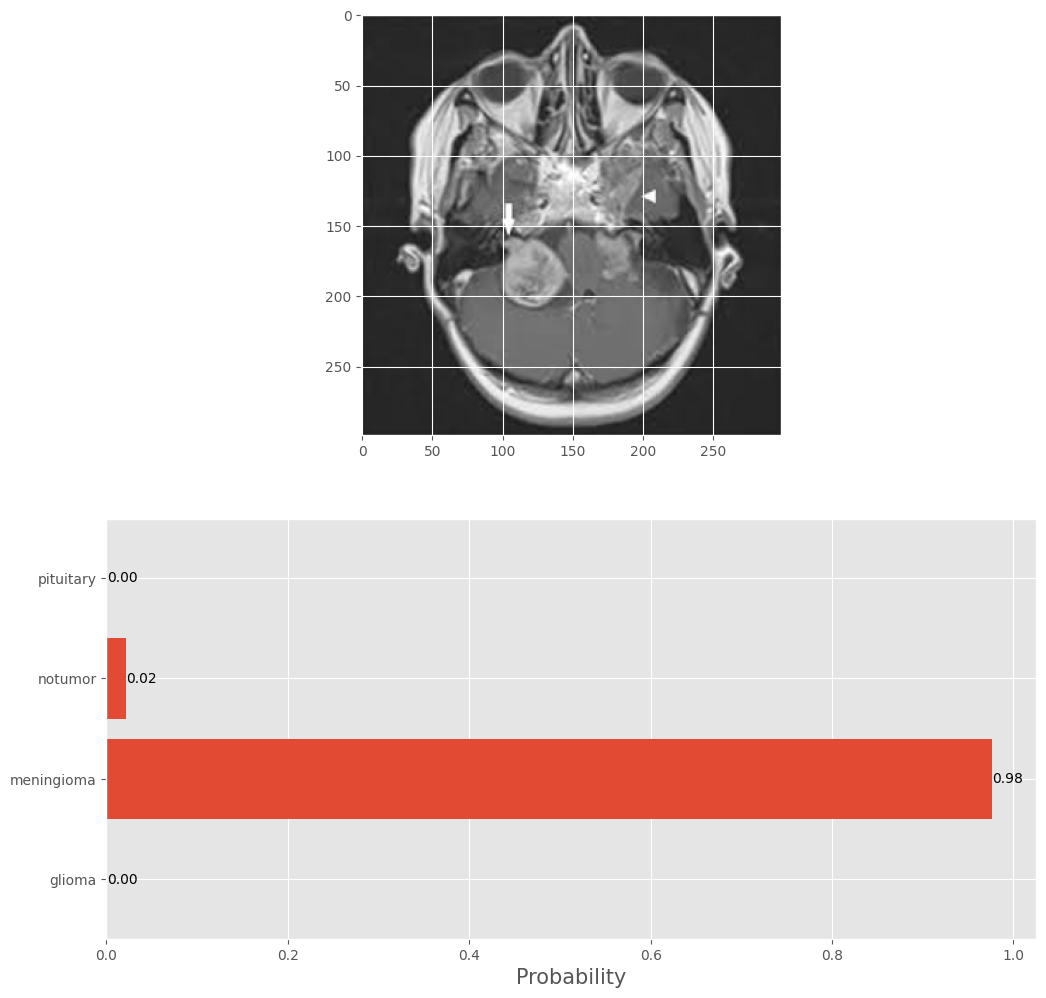

In [33]:
predict('/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma/Te-meTr_0002.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


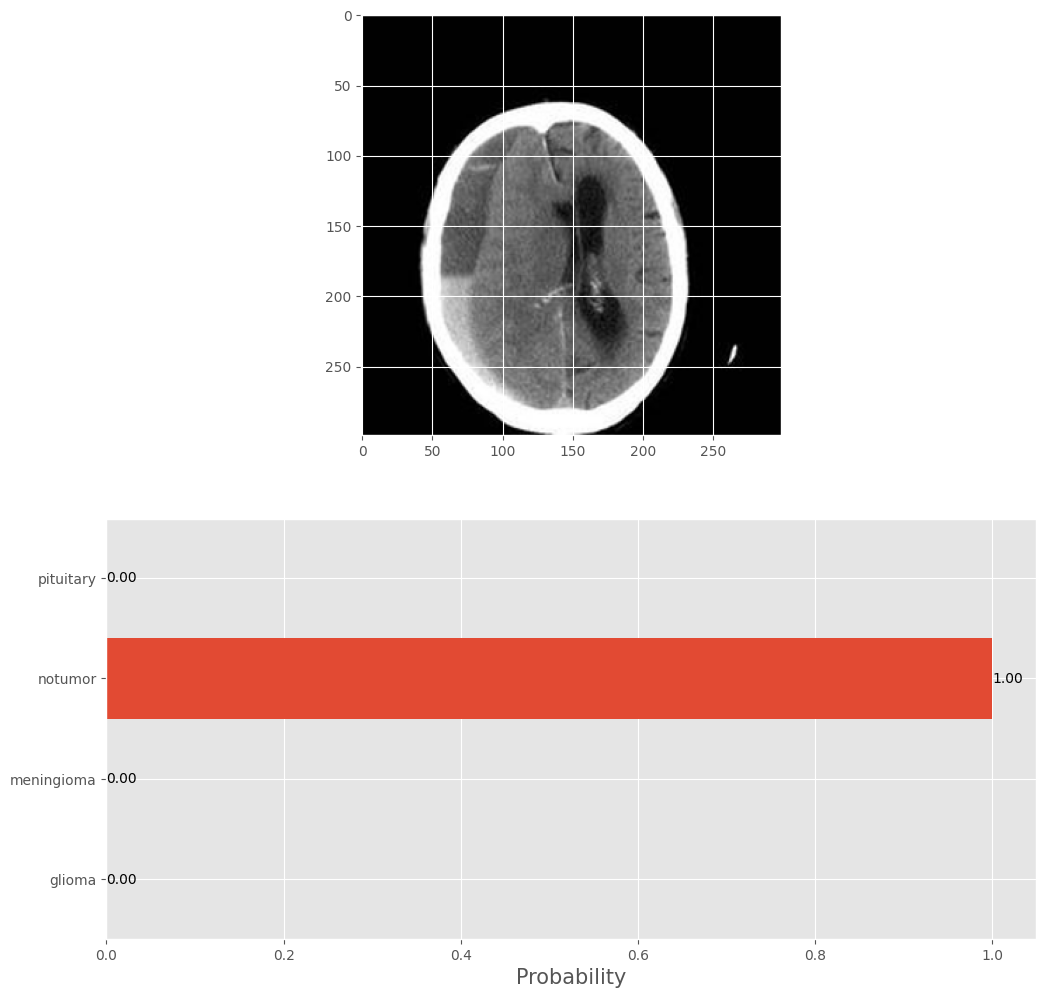

In [34]:
predict('/kaggle/input/brain-tumor-mri-dataset/Testing/notumor/Te-noTr_0000.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


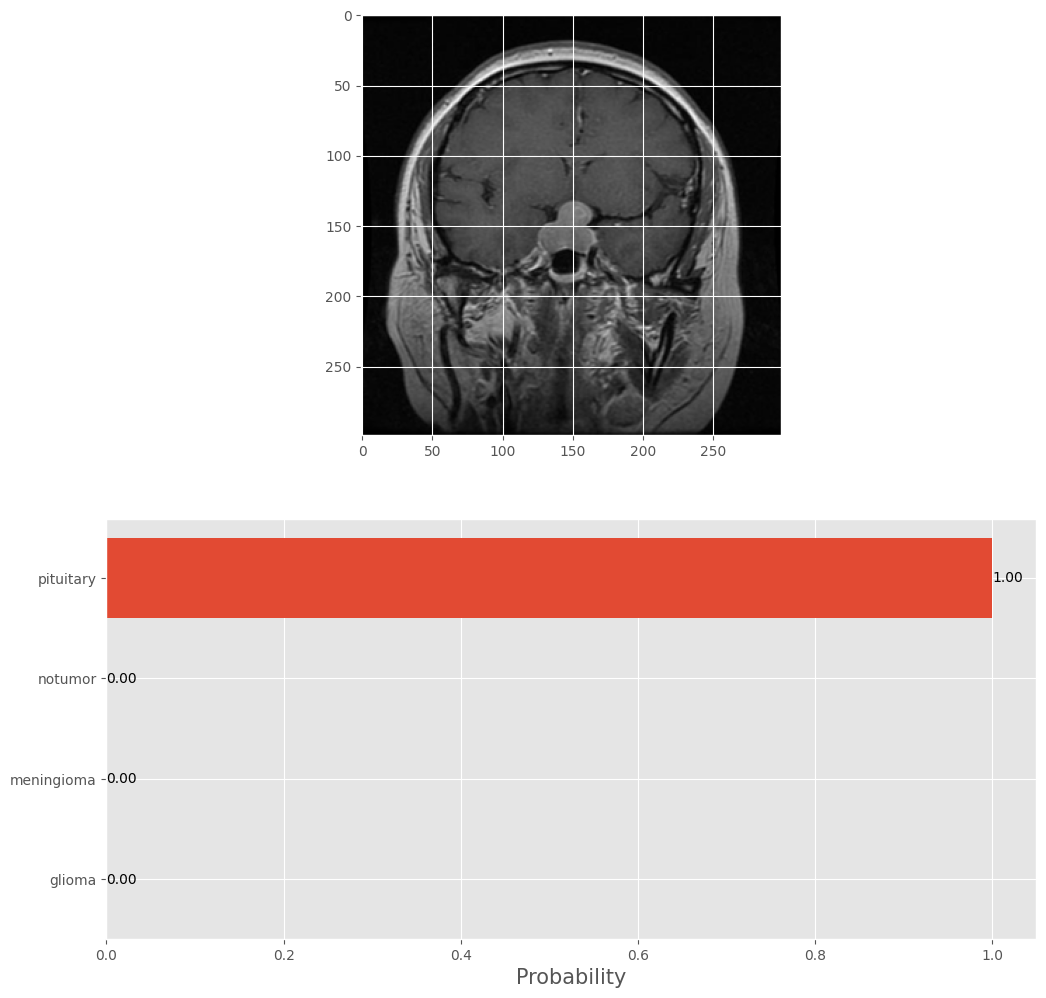

In [35]:
predict('/kaggle/input/brain-tumor-mri-dataset/Testing/pituitary/Te-piTr_0001.jpg')

In [37]:
import os
os.listdir("/kaggle/working")


['.virtual_documents', 'brain_tumor.h5', 'model.png']

In [38]:
from IPython.display import FileLink
FileLink(r'brain_tumor.h5')

/kaggle/working/brain_tumor.h5